In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import random as rd

# plots
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rc('font', size = 12)
plt.rc('figure', titlesize = 20)
plt.rc('axes', labelsize = 12)
plt.rc('axes', titlesize = 15)

# models
import statsmodels.stats as sts
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.anova as aov
import statsmodels.stats.outliers_influence as sso
import statsmodels.stats.diagnostic as ssd
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('IEXL')

Mounted at IEXL


In [3]:
gifted = pd.read_csv('/content/IEXL/My Drive/IEXL - Bootcamp - Math&Stats 20-21 September/data/gifted.csv')
gifted.head(5)

,score,fatheriq,motheriq,speak,count,read,edutv,cartoons
0,159,115,117,18,26,1.9,3.00,2.00
1,164,117,113,20,37,2.5,1.75,3.25
2,154,115,118,20,32,2.2,2.75,2.50
3,157,113,131,12,24,1.7,2.75,2.25
4,156,110,109,17,34,2.2,2.25,2.50


In [4]:
max(gifted['score']), min(gifted['score'])

(169, 150)

## Multicollinearity Analysis

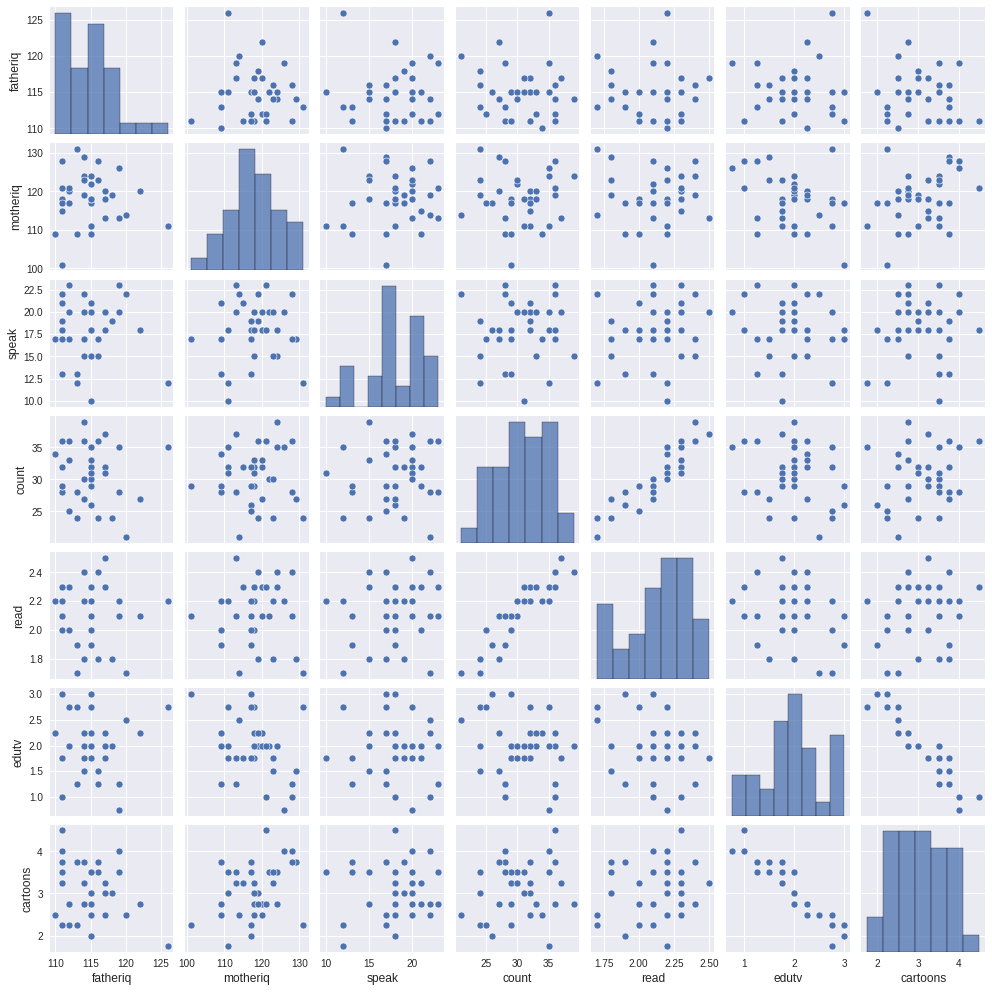

In [5]:
sns.pairplot(gifted.drop('score', axis = 1),
             height = 2)
plt.show()

In [6]:
gifted.drop('score', axis = 1).corr()**2

,fatheriq,motheriq,speak,count,read,edutv,cartoons
fatheriq,1.000000,0.000616,0.000933,0.005628,0.004654,0.013507,0.061678
motheriq,0.000616,1.000000,0.005211,0.000589,0.001852,0.108899,0.114527
speak,0.000933,0.005211,1.000000,0.003546,0.034251,0.023878,0.011960
count,0.005628,0.000589,0.003546,1.000000,0.828559,0.046517,0.023994
read,0.004654,0.001852,0.034251,0.828559,1.000000,0.027743,0.015809
edutv,0.013507,0.108899,0.023878,0.046517,0.027743,1.000000,0.852736
cartoons,0.061678,0.114527,0.011960,0.023994,0.015809,0.852736,1.000000


In [7]:
X = gifted.drop('score', axis = 1)
X['Intercept'] = 1

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.dropna().values, i)for i in range(X.shape[1])]

print(vif)

   variables          VIF
0   fatheriq     1.196214
1   motheriq     1.172998
2      speak     1.182755
3      count     6.886769
4       read     6.896808
5      edutv     8.214684
6   cartoons     8.373075
7  Intercept  3096.694544


We should drop either read/count and either edutv/cartoons

## Model

In [8]:
model = ols('score ~ fatheriq + motheriq + speak + count', data = gifted).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     18.76
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           6.28e-08
Time:                        10:16:25   Log-Likelihood:                -83.607
No. Observations:                  36   AIC:                             177.2
Df Residuals:                      31   BIC:                             185.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.0484     17.731      2.935      0.0

In [9]:
#RSE
resids = model.resid
n = model.nobs
K = len(model.model.exog[0]) - 1

RSS = sum(resids**2)
RSE = np.sqrt(RSS/(n-K-1))

print("The Residuals Standard Error is {:4.2f}".format(RSE))

The Residuals Standard Error is 2.66


## <font color = "blue">Multiple Restrictions </font>

Let's first test if the impact of fathers and mothers is the same:

\begin{equation}
H_0:\{\beta_{fatheriq}=\beta{motheriq}\}
\end{equation}

then we define

\begin{equation}
d = \beta_{fatheriq} - \beta{motheriq}
\end{equation}

and the model to estimate becomes

\begin{equation}
\text{score} = \beta_0+\beta_1\, TotalIQ + d\,\text{motheriq}+ \beta_3\,\text{speak} + \beta_4\,\text{count}
\end{equation}

The second test that we are going to do is the analysis of 

\begin{equation}
H_0:\{\beta_{speak} = 0, \beta_{count}=0\}
\end{equation}

I need to estimate the models with and without the variables involved

In [10]:
model_restricted = ols('score ~ fatheriq + motheriq', data = gifted).fit()
print(model_restricted.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     9.577
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           0.000525
Time:                        10:16:25   Log-Likelihood:                -97.509
No. Observations:                  36   AIC:                             201.0
Df Residuals:                      33   BIC:                             205.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.7786     24.401      3.270      0.0

In [11]:
aov.anova_lm(model_restricted, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,33.0,474.756232,0.0,NaN,NaN,NaN
1,31.0,219.307843,2.0,255.448388,18.054302,0.000006


since the p-value is smaller than the SL we reject the NULL hypothesis and conclude that the model WITH the variables included is better to explain the variability of the response

In [12]:
model_restricted_2 = ols('score ~ speak + count', data = gifted).fit()
print(model_restricted_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     8.956
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           0.000782
Time:                        10:16:25   Log-Likelihood:                -97.943
No. Observations:                  36   AIC:                             201.9
Df Residuals:                      33   BIC:                             206.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    135.5709      5.741     23.614      0.0

In [13]:
aov.anova_lm(model_restricted_2, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,33.0,486.339082,0.0,NaN,NaN,NaN
1,31.0,219.307843,2.0,267.031239,18.872942,0.000004


## <font color = "Red"> Validation </font>

The validation goes along these lines:

 * Multicolinearity (already checked)
 * Linear Description: absence of misspecification problems (Ramsey. Harvey-Collier)
 * Zero expected value and normality of the residuals (Shapiro-Wilk, D'Agostino)
 * Independency of the residuals (Durbin-Watson test)
 * Homoskedasticity (White, Breusch-Pagan,...)

### <font color="Blue"> Linear Description </font>

The H0 of the test is that the model is properly specified (no need of extra variables)

In [14]:
sso.reset_ramsey(model, degree = 2)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.20494805]]), p=0.6540132945661091, df_denom=30, df_num=1>

the p-value implies that there are no problems with misspecification of the model (we don't need to include higher degrees in the variables)

In [15]:
sms.linear_harvey_collier(model)

Ttest_1sampResult(statistic=nan, pvalue=nan)

In [16]:
# The residuals are "resids"
fitted = model.fittedvalues
abs_resids = np.abs(resids)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


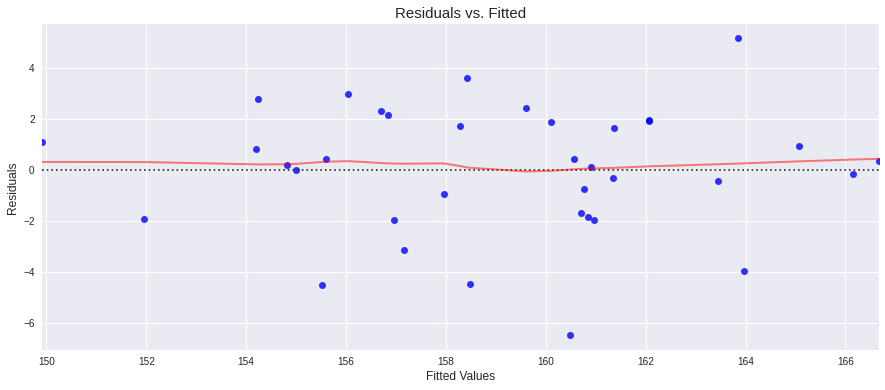

In [17]:
f = plt.figure()
f.set_figheight(6)
f.set_figwidth(15)

f.axes[0] = sns.residplot(fitted, 'score', data = gifted,
                          lowess = True,
                          scatter_kws = {'color': 'blue'},
                          line_kws = {'color': 'red', 'lw': 2, 'alpha': 0.5})
f.axes[0].set_title("Residuals vs. Fitted")
f.axes[0].set_xlabel("Fitted Values")
f.axes[0].set_ylabel("Residuals")

plt.show()

### <font color ="Blue">Zero Expected Value and Normality </font>

To check the expected value, we just find the average of the residuals

In [18]:
resids.mean()

-8.842309600570136e-14

To check normality we are going to use:

 * Shapiro-Wilk test
 * D'Agostino

 In any of these tests,
 
\begin{equation}
H_0:\{\text{ normality} \}
\end{equation}

Then we can make a qq-plot (normal).

In [19]:
s_stat, s_pval = ss.shapiro(resids)
d_stat, d_pval = ss.normaltest(resids)

print("Shapiro-Wilk statistic: {:4.2f}\np-value: {:4.4f}".format(s_stat, s_pval))
print("D'Agostino statistic: {:4.2f}\np-value: {:4.4f}".format(d_stat, d_pval))

Shapiro-Wilk statistic: 0.97
p-value: 0.4706
D'Agostino statistic: 2.45
p-value: 0.2935


since the p-values are big enough we don't find evidence against the normality of the residuals.

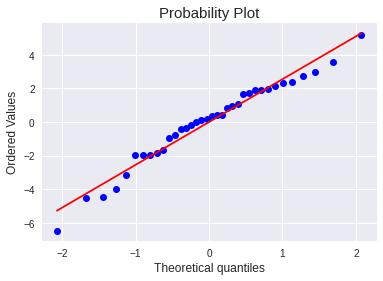

In [20]:
ss.probplot(resids, plot = sns.mpl.pyplot)
plt.show()

#### <font color = "darkBlue"> Transformation of Variables </font>

Suppose that the normality of the residuals is not satisfied, then we may need a transformation of the response variable $y$ in order to get the right distribution. The best way is using the Box-Cox transformation 

\begin{equation}
y^{(\lambda)} = \left\{\begin{array}{lr}
\displaystyle\frac{y^\lambda - 1}{\lambda}, & \lambda\neq 0 \\[2ex]
\log\lambda, & \lambda = 0
 \end{array}\right.
\end{equation}

But the method relies in finding the proper value of $\lambda$. This is done by using the value such that likelihood of normality is maximized. This can be found to be

\begin{equation}
\log L(\beta,\sigma)=-\frac{n}{2}\left( y^{(\lambda)T}\left(I - X(X^TX)^{-1}X^T\right)y^{(\lambda)}\right) + \log J
\end{equation}

where $J$ is the jacobian of the transformation, $\beta$ are the coefficients of the linear model and $\sigma$ is the variance of the errors.

Then, let's see how to find it

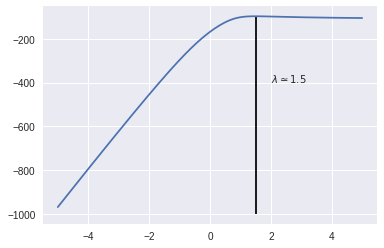

In [21]:
def log_likelihood(lmbda, x, y):
    n, p = x.shape
    log_jacobi = (lmbda - 1) * np.sum(np.log(y))
    trans_y = ss.boxcox(y, lmbda=lmbda)
    coeffs = np.linalg.inv(np.matmul(np.transpose(x), x))
    K = np.subtract(np.identity(n), np.matmul(np.matmul(x, coeffs), np.transpose(x)))
    rss = np.matmul(np.matmul(np.transpose(trans_y), K), trans_y)
    return - n / 2.0 * np.log(rss) + log_jacobi

lambda_values = np.arange(-5,5,0.01)
x = np.array(gifted[['fatheriq', 'motheriq', 'speak', 'count']])
y = gifted['score']
likelihoods = np.array([log_likelihood(l, x, y) for l in lambda_values])

box_cox_powers = pd.DataFrame({'lambda': lambda_values, 'likelihood': likelihoods})
power = box_cox_powers.loc[box_cox_powers['likelihood'].idxmax(), 'lambda']

plt.plot(lambda_values, likelihoods)
plt.vlines(power, -1000, -100)
plt.text(2,-400, r'$\lambda\simeq 1.5$')
plt.show()

### <font color = "Blue"> Autocorrelation </font>

We speak of autocorrelation when the values of the variable depend on the values of the variable itself. This, known as serial correlation can be written in the form of a linear model

\begin{equation}
e_t = \rho\, e_{t-1}+ u_t
\end{equation}

where the null hypothesis for the relevancy of the model is

\begin{equation}
H_0:\{\rho = 0\}
\end{equation}

and this implies that if we fail to reject the hypothesis, there is no serial correlation. 

In our case we may lag the residuals, estimate the corresponding model and then analyse the individual significance of the variable



In [22]:
residuals = pd.DataFrame({'residuals': resids,
                          'lag_resids': resids.shift()})
autocorrelation_model = ols('residuals ~ lag_resids', data = residuals).fit()
print(autocorrelation_model.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                  0.004667
Date:                Tue, 20 Oct 2020   Prob (F-statistic):              0.946
Time:                        10:16:27   Log-Likelihood:                -81.045
No. Observations:                  35   AIC:                             166.1
Df Residuals:                      33   BIC:                             169.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0850      0.427     -0.199      0.8

from here we identify a p-value of 0.946 for $\rho$ which implies that we fail to reject the NULL hypothesis and the conclusion is that we do not find any evidence of serial correlation.

#### <font color = "darkBlue"> Durbin-Watson Statistic </font>

There is another form of testing for autocorrelation by using the Durbin-Watson statistic, defined as

\begin{equation}
DW = \dfrac{\sum_{t=2}^n(\hat e_t-\hat e_{t-1})^2}{\sum_{t=1}^n \hat e_t^2}\approx 2(1-\hat\rho)
\end{equation}

due to the last relation the test on $\rho$ is completely equivalent to the test on DW. Now, we see that if $\hat\rho = 0$, i.e. it is statistically not significant, $DW=2$, reason why we will usually see that when the value of the DW statistic is around 2, we can declare independency. In the same way, when $\hat\rho >0$ (positive correlation) we find $DW < 2$ and the other way around, when $\hat\rho <0$ (negative correlation) we find $DW > 2$.

In the case of our modelwe have that

In [23]:
sts.stattools.durbin_watson(resids)

1.9212365668452218

and the we may say that the value is close enough to 2 as to assume independency or that, in any case we detect a very low negative autocorrelation.

However, the relation is not exact, just an approximation (due to the denominator) and then the probability distribution fo DW depends on the values of the independent variable, the number of regressors, the sample size and on whether or not the model contains an intercept. Too many things to immediately declare independency with a value around 2. 

Formally we can find a tabulation the values of the DW distribution (Savin-White) that return a high ($d_U$) and low ($d_L$) values such that

 * If $DW < d_L$ we reject the NULL in favor of $H_1:\{\rho >0\}$
 * If $DW > d_U$ we fail to reject the NULL, and do not find evidence of autocorrelation
 * If $d_L < DW < d_U$ the test is inconclusive

Then again, in our case we have

In [24]:
print('{:<20} {:>4.0f}\n{:<20} {:>4.0f}'.format('sample size: ', n, 'Number of Regressors: ', K))

sample size:           36
Number of Regressors:     4


looking at the tables this implies that $d_L=1.043$ and $d_U = 1.513$, then our value is greater than the upper limit and then we fail to reject the null hypothesis, meaning that we do not find evidence against the lack of autocorrelation.

In any case, the three methods we have followed contain the same conclussion: there is no autocorrelation in the residuals.

### <font color = "Blue"> Heteroskedasticity </font>

In this case the decision scheme is

\begin{equation}
H_0:\{\text{homoskedastic}\},\qquad H_1:\{\text{heteroskedastic}\}
\end{equation}

In [25]:
values = ['Multiplier', 'p-value', 'F statistic', 'Fp-value']
bp_test = ssd.het_white(resids, model.model.exog)
lzip(values, bp_test)

[('Multiplier', 12.066473512641391),
 ('p-value', 0.6009643535753493),
 ('F statistic', 0.7562492004060551),
 ('Fp-value', 0.7003842104369167)]

In [26]:
values = ['Multiplier', 'p-value', 'F statistic', 'Fp-value']
bp_test = ssd.het_breuschpagan(resids, model.model.exog)
lzip(values, bp_test)

[('Multiplier', 3.7813476121400305),
 ('p-value', 0.4364051690975719),
 ('F statistic', 0.9095800668909282),
 ('Fp-value', 0.47055902736679234)]

Both tests return p-values large enough as to consider that we have problems, then we do not find evidence agains homoskedasticity.

## <font color = "Red"> Influential Points </font>

The pieces of information that we need are

 * Studentized (standarized) residuals
 * Leverage
 * Cook's Distance
 * Squared and Absolute Value Residuals

In [27]:
influential = model.get_influence()
inf_data = influential.summary_frame()
inf_data.head()

,dfb_Intercept,dfb_fatheriq,dfb_motheriq,dfb_speak,dfb_count,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.060342,-0.003923,-0.031847,0.015168,-0.218182,0.017489,1.145854,0.062441,0.295710,1.151878,0.297265
1,-0.079377,0.104900,-0.120086,0.086149,0.210187,0.018858,0.779042,0.134469,0.307065,0.773987,0.305073
2,0.076752,-0.047759,0.034872,-0.288114,-0.129656,0.053350,-2.490078,0.041246,-0.516479,-2.738748,-0.568056
3,-0.010876,0.056322,-0.190252,0.172859,0.136592,0.018879,-0.439144,0.328628,-0.307240,-0.433353,-0.303189
4,0.053110,-0.041488,-0.043823,-0.008829,0.021764,0.001061,0.168497,0.157429,0.072834,0.165833,0.071682


In [28]:
std_resids = inf_data.student_resid
leverage = inf_data.hat_diag
cooks = inf_data.cooks_d
sq_resid = np.sqrt(np.abs(std_resids))
norm_resids = influential.resid_studentized_internal

n = model.nobs
K = len(model.model.exog[0]) - 1

### <font color = "Blue"> Outliers </font>

In [29]:
t_crit = abs(ss.t.ppf(0.05/(2*n), n-K-1))
outlier = [i for i in abs(std_resids) if i >= t_crit]
std_resids.index[std_resids > t_crit]

Int64Index([], dtype='int64')

### <font color = "Blue"> Leverage </font>

In [30]:
boundary = 2*(K+1)/n
high_leverage = [i for i in leverage if i >= boundary]
leverage.index[leverage > boundary]

Int64Index([3, 13, 18], dtype='int64')

### <font color = "Blue"> Influential Points </font>

In [31]:
D = 4/(n+K-1)
influential = [i for i in cooks if i >= D]
cooks.index[cooks > D]

Int64Index([23], dtype='int64')

In [32]:
gifted.iloc[23, :]

score       169.00
fatheriq    112.00
motheriq    121.00
speak        23.00
count        36.00
read          2.30
edutv         2.00
cartoons      2.75
Name: 23, dtype: float64

### <font color = "Blue"> Graphical Analysis </font>

We are going to find the residuals plot of the model and then use the critical t-values to mark the range where we can find the outliers

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


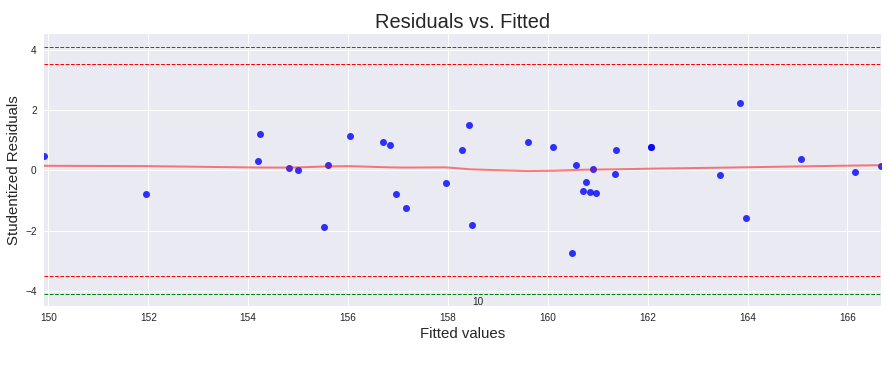

In [33]:
plt.figure(figsize = (15, 5))
# sns.residplot(fitted, 'score', data = gifted)
sns.regplot(fitted, std_resids,
            scatter = True,
            lowess = True,
            scatter_kws = {'color': 'blue'},
            line_kws = {'color': 'red', 'lw': 2, 'alpha': 0.5})

plt.title("Residuals vs. Fitted", fontsize = 20)
plt.xlabel('Fitted values', fontsize = 15)
plt.ylabel('Studentized Residuals', fontsize = 15)

abs_resids_top = abs_resids.sort_values(ascending=False)[:4]
for i in abs_resids_top.index:
  plt.annotate(i, xy = (fitted[i],
                        resids[i]))

plt.hlines(ss.t.ppf(0.05/(2*n), n-K-1), min(fitted), max(fitted), color = "red", linestyles='--', linewidth = 1)
plt.hlines(ss.t.isf(0.05/(2*n), n-K-1), min(fitted), max(fitted), color = "red", linestyles='--', linewidth = 1)
plt.hlines(ss.t.ppf(0.01/(2*n), n-K-1), min(fitted), max(fitted), color = "green", linestyles='--', linewidth = 1)
plt.hlines(ss.t.isf(0.01/(2*n), n-K-1), min(fitted), max(fitted), color = "green", linestyles='--', linewidth = 1)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


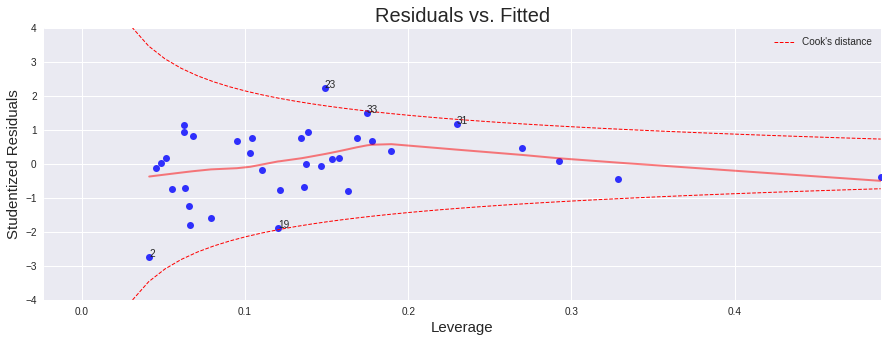

In [34]:
def graph(formula, x_range, label = None):
  x = x_range
  y = formula(x)
  plt.plot(x, y, label = label, lw = 1, ls = '--', color = "red")


plt.figure(figsize = (15, 5))
sns.regplot(leverage, std_resids,
            scatter = True,
            lowess = True,
            scatter_kws = {'color': 'blue'},
            line_kws = {'color': 'red', 'lw': 2, 'alpha': 0.5})

plt.title("Residuals vs. Fitted", fontsize = 20)
plt.xlabel('Leverage', fontsize = 15)
plt.ylabel('Studentized Residuals', fontsize = 15)

cooks_top = cooks.sort_values(ascending=False)[:5]
for i in cooks_top.index:
  plt.annotate(i, xy = (leverage[i],
                        std_resids[i]))

graph(lambda x: np.sqrt((D*(K+1)*(1-x))/x),
      np.linspace(0.001, max(leverage), 50),
      'Cook\'s distance')
graph(lambda x: -np.sqrt((D*(K+1)*(1-x))/x),
      np.linspace(0.001, max(leverage), 50))
plt.legend(loc = 'best')
plt.ylim(-4,4)

plt.show()

## <font color = "Blue"> Categorial Variables </font>



Since we do not have any categorial variable in the dataset, we are going to *invent* one using a random generator

In [35]:
def rand_gl(x, m, name = None, labels = None):
    '''
    Creation of a randomly generated factor series of pandas
    
    INPUT:
    x: value that determines the number of possible categories, since we begin at 0, a velue of 1 will imply 2 categories
    m: length of the vector
    name: default values of the input values: 0, 1,... The number of names cannot be in disagreement with the value of x
    labels: labels of the categories. The number of labels cannot be in disagreement with the value of x
    
    OUTPUT:
    the output is a categorical vector of length m with labels given by the names or the labels with 
    '''
    cat = []
    for i in range(m):
        cat += [rd.randint(0, x)]
    
    if name is None:
        cat = pd.Series(cat, dtype = 'category', name = 'categories')
    else:
        cat = pd.Series(cat, dtype = 'category', name = name)
    
    if labels is None:
        return(cat)
    else:
        cat = cat.cat.rename_categories(labels)
        return(cat)

In [45]:
np.random.seed(1)
gifted['female'] = rand_gl(1, len(gifted), labels = ['1', '0'])
gifted.head()

,score,fatheriq,motheriq,speak,count,read,edutv,cartoons,female
0,159,115,117,18,26,1.9,3.00,2.00,0
1,164,117,113,20,37,2.5,1.75,3.25,1
2,154,115,118,20,32,2.2,2.75,2.50,1
3,157,113,131,12,24,1.7,2.75,2.25,0
4,156,110,109,17,34,2.2,2.25,2.50,1


In [48]:
model_cat = ols('score ~ fatheriq + motheriq + speak + count + C(female)', data = gifted).fit()
print(model_cat.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     14.81
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           2.43e-07
Time:                        10:41:23   Log-Likelihood:                -83.360
No. Observations:                  36   AIC:                             178.7
Df Residuals:                      30   BIC:                             188.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         50.9000     17.989      2.

Now we are going to use `patsy` to define the interactions between the variable and any other variable in the model

In [52]:
features = ['fatheriq', 'motheriq', 'speak', 'count']
X = gifted[features]

model_cat_full = ols('score ~ C(female) * X', data = gifted).fit()
print(model_cat_full.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     8.222
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           1.12e-05
Time:                        10:43:57   Log-Likelihood:                -81.499
No. Observations:                  36   AIC:                             183.0
Df Residuals:                      26   BIC:                             198.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              43.4405    

The model we find is

\begin{equation}
\text{score} = 43.44+0.32\,\text{fiq} + 0.45\,\text{miq}\dots +0.13\,\text{fiq}\cdot\text{female} +\dots + 8.39\,\text{female}
\end{equation}

then, we can split the model in the two possible categories:

\begin{equation}
\text{score}^f \approx 51 + 0.45\,\text{fiq} + 0.33\,\text{miq}\dots\qquad \text{score}^{nf} \approx 43 + 0.32\,\text{fiq} + 0.45\,\text{miq}\dots
\end{equation}

We can interpret for example the impact of being a female with respect to the `fatheriq` variable: *for the same levels of `motheriq`, `speak` and `count`, for each unit increase in the father's iq, on average, female gifted children will have a higher iq of 0.13 units*

### <font color = "Blue"> Chow Test </font>

if we have a model like

\begin{equation}
\text{response} = \beta_0 + \beta_1\,x_1 + \beta_2\,x_2 +\delta_1\text{cat} + \delta_2\,x_1\cdot\text{cat}+\delta_3\,x_2\cdot\text{cat}
\end{equation}

we can perform two different multiple restriction tests:

\begin{equation}
H_0:\{\delta_1=0,\,\delta_2=0,\,\delta_3=0\}\qquad H_0:\{\delta_2=0,\,\delta_3=0\}
\end{equation}

the first one is the classical Chow test and the F-dsitribution statistic that we have to compute is

\begin{equation}
F = \frac{SSR_p - (SSR_1 + SSR_0)}{SSR_1 + SSR_0}\frac{T-2(K+1)}{K+1}
\end{equation}

ini here we have three models:

 * **Pooled model**: The model when we do not consider the categorial variable (in any sense). Here we find $SSR_p$ and $T$ which is just the number of observations in the pooled model (sample size)
 * Models for each of the categories estimated separatedly (**model 1** and **model 0**), here we find $SSR_1$ and $SSR_0$

In any of the models we find the value of $K$: the number of regressors.

In [56]:
# Models
pooled = ols('score ~ fatheriq + motheriq + speak + count', data = gifted).fit()
model_0 = ols('score ~ fatheriq + motheriq + speak + count', data = gifted[gifted.female == '0']).fit()
model_1 = ols('score ~ fatheriq + motheriq + speak + count', data = gifted[gifted.female == '1']).fit()

# T and K
T = pooled.nobs
K = len(pooled.model.exog[0]) - 1

# Sum of square residuals
SSRp = sum(pooled.resid**2)
SSR0 = sum(model_0.resid**2)
SSR1 = sum(model_1.resid**2)

# F-statistic
Fstat = ((SSRp - (SSR0 + SSR1))/(SSR0 + SSR1))*((T - 2*(K+1))/(K+1))
Fpval = 1 - ss.f.cdf(Fstat, K+1, n-2*(K+1))

Fpval

0.6669630590827909

If we want to test only the slopes we use the following statistic

\begin{equation}
F = \frac{SSR_p - (SSR_1 + SSR_0)}{SSR_1 + SSR_0}\frac{T-2(K+1)}{K}
\end{equation}

In [57]:
# F-statistic
Fstat = ((SSRp - (SSR0 + SSR1))/(SSR0 + SSR1))*((T - 2*(K+1))/(K))
Fpval = 1 - ss.f.cdf(Fstat, K, n-2*(K+1))

Fpval

0.5317356000765243